# Code for the paper: 

## Efficient and Mobile Deep Learning Architectures for Fast Identification of BacterialStrains in Resource-Constrained Devices

### Architecture: EfficientNet B1
### Data: Original + Cross-Validation

In [1]:
# !cp -r /kaggle/input/dibas-dataset/ /kaggle/working/data/

In [2]:
# !rm -r /kaggle/working/data/Acinetobacter.baumanii/

In [3]:
# !cp -r /kaggle/input/dibas-dataset/Acinetobacter.baumanii/Acinetobacter.baumanii/ /kaggle/working/data/Acinetobacter.baumanii/

In [4]:
import shutil
import os

shutil.copytree('/kaggle/input/dibas-dataset','/kaggle/working/data')

'/kaggle/working/data'

In [5]:
dest = "/kaggle/working/data/Acinetobacter.baumanii"

for element in os.listdir("/kaggle/working/data/Acinetobacter.baumanii/Acinetobacter.baumanii"):
    shutil.copy(f"/kaggle/working/data/Acinetobacter.baumanii/Acinetobacter.baumanii/{element}",dest)
    
shutil.rmtree("/kaggle/working/data/Acinetobacter.baumanii/Acinetobacter.baumanii",ignore_errors=True)
os.remove('/kaggle/working/data/Micrococcus.spp/Micrococcus.spp_0023.tif')
os.remove('/kaggle/working/data/Micrococcus.spp/Micrococcus.spp_0021.tif')
os.remove('/kaggle/working/data/Listeria.monocytogenes/Listeria.monocytogenes_0023.tif')

#### Loading libraries

In [6]:
!pip install pytorch-model-summary

In [7]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=8b5e19be48e30e0e734e077ec1a17bf0d955b07175e17e4292b88518d9d70acd
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [8]:
# Imports here
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch.nn.functional as F
import pandas as pd
import time
import numpy as np

from PIL import Image
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import KFold
from torch import nn
from torch import optim
from torch.utils.data import SubsetRandomSampler
from torchvision import datasets, transforms, models
from pytorch_model_summary import summary

# Archs not in Pytorch
from efficientnet_pytorch import EfficientNet

# External functions
# from scripts.utils import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
from sklearn.metrics import precision_score, recall_score
import pandas as pd
import torch

class prediction:
    def __init__(self, ground_truth, top5_classes, top5_probs):
        self.ground_truth = ground_truth
        self.top5_classes = top5_classes
        self.top5_probs = top5_probs

    def get_gt(self):
        return self.ground_truth

    def get_top5_classes(self):
        return self.top5_classes

    def get_top5_probs(self):
        return self.top5_probs

def get_classes(probabilities, idx_to_class):
    # Most probable class
    top_probabilities, top_indices = probabilities.topk(5)

    top_probabilities = torch.nn.functional.softmax(top_probabilities, dim=1)

    # Convert to lists
    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0]
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0]

    # Convert topk_indices to the actual class labels using class_to_idx
    # Invert the dictionary so you get a mapping from index to class.
    #print(idx_to_class)

    top_classes = [idx_to_class[index] for index in top_indices]

    return top_probabilities, top_classes

def test_accuracy(model, test_loader):

    evaluation_results = []

    # Do validation on the test set
    model.eval()

    if torch.cuda.is_available():
        model = model.cuda()

    with torch.no_grad():

        accuracy = 0

        for images, labels in iter(test_loader):

            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            output = model.forward(images)

            probabilities = torch.exp(output)

            # Getting indices to their corresponding classes
            idx_to_class = {value: key for key, value in model.class_to_idx.items()}

            probs, classes = get_classes(probabilities, idx_to_class)

            # List with results to form a confusion matrix
            hr_label = labels.data.detach().type(torch.FloatTensor).numpy().tolist()[0]

            hr_label = idx_to_class[hr_label]

            pred = prediction(hr_label, classes, probs)
            evaluation_results.append(pred)

    print("Finished.")

    return evaluation_results

def results_pandas(model, test_loader):

    # Getting results
    results = test_accuracy(model, test_loader)

    gt = []
    top1 = []
    certainty = []

    results_dict = {'Ground truth': [],
                    'Top 1 prediction': [],
                    'Certainty': [],
                    'Top 1 Correct': [],
                    'Top 5 Correct': []}

    # Preparing data to create a Pandas DataFrame
    for result in results:
        results_dict['Ground truth'].append(result.get_gt())
        results_dict['Top 1 prediction'].append(result.get_top5_classes()[0])
        results_dict['Certainty'].append(result.get_top5_probs()[0])
        results_dict['Top 1 Correct'].append(1 if result.get_gt() == result.get_top5_classes()[0] else 0)
        results_dict['Top 5 Correct'].append(1 if result.get_gt() in result.get_top5_classes() else 0)

    results_df = pd.DataFrame(results_dict)

    return results_df

def get_scores(model, valid_loader):
    
    # Tracking variables 
    num_correct = 0
    num_samples = 0
    top3_correct = 0
    top5_correct = 0
    
    # No gradient tracking needed
    with torch.no_grad():
        # Iterate through validation set
        for x, y in valid_loader:
            # Get predictions 
            scores = model(x)

            # Get top 3
            top3, top3_indices = scores.topk(3, dim=1) 
            top3_correct += torch.sum(top3_indices == y.unsqueeze(dim=1), dim=1).any().item()

            # Get top 5
            top5, top5_indices = scores.topk(5, dim=1)
            top5_correct += torch.sum(top5_indices == y.unsqueeze(dim=1), dim=1).any().item() 

            # Update tracking variables
            num_correct += (scores.argmax(1) == y).sum().item()
            num_samples += scores.shape[0]

        # Calculate accuracy
        acc = float(num_correct) / num_samples
        top3_acc = float(top3_correct) / num_samples 
        top5_acc = float(top5_correct) / num_samples
        
#         precision = precision_score(y, pred_labels)
#         recall = recall_score(y, pred_labels)

        print(f'Acc: {100*acc:.2f}%')
#         print(f'Precision: {100*precision:.2f}%')
#         print(f'Recall: {100*recall:.2f}%')
        print(f'Top-3 Acc: {100*top3_acc:.2f}%') 
        print(f'Top-5 Acc: {100*top5_acc:.2f}%')

In [10]:
print(torch.__version__)

import sys
print(sys.version)

2.0.0
3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]


## Data paths and hyperparameters

#### Hyperparameters and dataset details. 

In [11]:
# Dataset details
dataset_version = 'original' # original or augmented
img_shape = (224,224)
img_size = str(img_shape[0])+"x"+str(img_shape[1])

# Root directory of dataset
data_dir = '/kaggle/working/data'

train_batch_size = 32
val_test_batch_size = 32
feature_extract = False
pretrained = True
h_epochs = 50
kfolds = 10

## Data preparation and loading

#### Defining transforms and creating dataloaders

In [12]:
# Define transforms for input data
training_transforms = transforms.Compose([transforms.Resize((224,224), Image.LANCZOS),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
total_set = datasets.ImageFolder(data_dir, transform=training_transforms)

# Defining folds
splits = KFold(n_splits = kfolds, shuffle = True, random_state = 42)

#### Visualizing the target classes in dataset

In [13]:
train_labels = {value : key for (key, value) in total_set.class_to_idx.items()}
    
print(len(train_labels)) 
print(train_labels)

33
{0: 'Acinetobacter.baumanii', 1: 'Actinomyces.israeli', 2: 'Bacteroides.fragilis', 3: 'Bifidobacterium.spp', 4: 'Candida.albicans', 5: 'Clostridium.perfringens', 6: 'Enterococcus.faecalis', 7: 'Enterococcus.faecium', 8: 'Escherichia.coli', 9: 'Fusobacterium', 10: 'Lactobacillus.casei', 11: 'Lactobacillus.crispatus', 12: 'Lactobacillus.delbrueckii', 13: 'Lactobacillus.gasseri', 14: 'Lactobacillus.jehnsenii', 15: 'Lactobacillus.johnsonii', 16: 'Lactobacillus.paracasei', 17: 'Lactobacillus.plantarum', 18: 'Lactobacillus.reuteri', 19: 'Lactobacillus.rhamnosus', 20: 'Lactobacillus.salivarius', 21: 'Listeria.monocytogenes', 22: 'Micrococcus.spp', 23: 'Neisseria.gonorrhoeae', 24: 'Porfyromonas.gingivalis', 25: 'Propionibacterium.acnes', 26: 'Proteus', 27: 'Pseudomonas.aeruginosa', 28: 'Staphylococcus.aureus', 29: 'Staphylococcus.epidermidis', 30: 'Staphylococcus.saprophiticus', 31: 'Streptococcus.agalactiae', 32: 'Veionella'}


## Model definition and inicialization

#### Freezing pre-trained parameters, finetunning the classifier to output 32 classes.

In [14]:
# Freeze pretrained model parameters to avoid backpropogating through them
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        print("Setting grad to false.")
        for param in model.parameters():
            param.requires_grad = False
    
    return model

def get_device():
    # Model and criterion to GPU
    if torch.cuda.is_available():
        return 'cuda'
    else:
        return 'cpu'

In [15]:
def load_model():
    # Transfer Learning
    model = EfficientNet.from_pretrained('efficientnet-b0')
    
    # Mode
    model = set_parameter_requires_grad(model, feature_extract)
    
    # Fine tuning
    # Build custom classifier
    model._fc = nn.Linear(in_features=1280,
                        out_features=33)
    return model

def create_optimizer(model):
    # Parameters to update
    params_to_update = model.parameters()

    if feature_extract:
        params_to_update = []
        for param in model.parameters():
            if param.requires_grad == True:
                params_to_update.append(param)

    else:
        n_params = 0
        for param in model.parameters():
            if param.requires_grad == True:
                n_params += 1


    # Loss function and gradient descent

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(params_to_update, 
                          lr=0.001, 
                          weight_decay=0.000004)
    
    return criterion.to(get_device()), model.to(get_device()), optimizer

## Training, validation and test functions

In [16]:
# len(labels)

In [18]:
# Variables to store fold scores
train_acc = []
train_loss = []
val_acc = []
val_loss = []
# test_top1_acc = []
# test_top5_acc = []
# test_precision = []
# test_recall = []
# test_f1 = []
# times = []

for fold, (train_idx, valid_idx) in enumerate(splits.split(total_set)):
    
    start_time = time.time()
    
    print('Fold : {}'.format(fold))
    
    # Train and val samplers
    train_sampler = SubsetRandomSampler(train_idx)
    print("Samples in training:", len(train_sampler))
    valid_sampler = SubsetRandomSampler(valid_idx)
    print("Samples in test:", len(valid_sampler))
    
    # Train and val loaders
    train_loader = torch.utils.data.DataLoader(
                      total_set, batch_size=train_batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(
                      total_set, batch_size=1, sampler=valid_sampler)
    
    device = get_device()
    
    criterion, model, optimizer = create_optimizer(load_model())
    
    # Training
    for epoch in range(h_epochs):
        
        model.train()
        running_loss = 0.0
        running_corrects = 0
        trunning_corrects = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
            running_loss += loss.item() * inputs.size(0)
            running_corrects += (preds == labels).sum()
            trunning_corrects += preds.size(0)
            

        epoch_loss = running_loss / trunning_corrects
        epoch_acc = (running_corrects.double()*100) / trunning_corrects
        train_acc.append(epoch_acc.item())
        train_loss.append(epoch_loss.item())
        
        print('\t\t Training: Epoch({}) - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, epoch_loss, epoch_acc))
        
        # Validation
        
        model.eval()  
        
        vrunning_loss = 0.0
        vrunning_corrects = 0
        num_samples = 0
        
        for data, labels in valid_loader:
            
            data = data.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            with torch.no_grad():
                outputs = model(data)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
            vrunning_loss += loss.item() * data.size(0)
            vrunning_corrects += (preds == labels).sum()
            num_samples += preds.size(0)
            
        vepoch_loss = vrunning_loss/num_samples
        vepoch_acc = (vrunning_corrects.double() * 100)/num_samples
        
        train_acc.append(vepoch_acc.item())
        train_loss.append(vepoch_loss.item())
        
        print('\t\t Validation({}) - Loss: {:.4f}, Acc: {:.4f}'.format(epoch, vepoch_loss, vepoch_acc))
    
    # Calculating and appending scores to this fold
    labels = labels.cpu()
    preds = preds.cpu()
    
    get_scores(model.to('cpu'), valid_loader)
    
    time_fold = time.time() - start_time
    times.append(time_fold)
    print("Total time per fold: %s seconds." %(time_fold))

Fold : 0
Samples in training: 620
Samples in test: 69


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 241MB/s]


Loaded pretrained weights for efficientnet-b0
		 Training: Epoch(0) - Loss: 1.9485, Acc: 60.4839
		 Validation(0) - Loss: 2.5328, Acc: 31.8841
		 Training: Epoch(1) - Loss: 0.3997, Acc: 88.0645
		 Validation(1) - Loss: 1.9360, Acc: 43.4783
		 Training: Epoch(2) - Loss: 0.3572, Acc: 89.8387
		 Validation(2) - Loss: 2.2025, Acc: 43.4783
		 Training: Epoch(3) - Loss: 0.3017, Acc: 91.1290
		 Validation(3) - Loss: 2.3013, Acc: 49.2754
		 Training: Epoch(4) - Loss: 0.1785, Acc: 95.3226
		 Validation(4) - Loss: 1.4487, Acc: 65.2174
		 Training: Epoch(5) - Loss: 0.0719, Acc: 98.5484
		 Validation(5) - Loss: 1.0132, Acc: 79.7101
		 Training: Epoch(6) - Loss: 0.1977, Acc: 93.8710
		 Validation(6) - Loss: 0.8941, Acc: 72.4638
		 Training: Epoch(7) - Loss: 0.1444, Acc: 95.8065
		 Validation(7) - Loss: 0.5503, Acc: 84.0580
		 Training: Epoch(8) - Loss: 0.0743, Acc: 98.5484
		 Validation(8) - Loss: 0.2146, Acc: 92.7536
		 Training: Epoch(9) - Loss: 0.0621, Acc: 98.0645
		 Validation(9) - Loss: 0.935

NameError: name 'pred_labels' is not defined

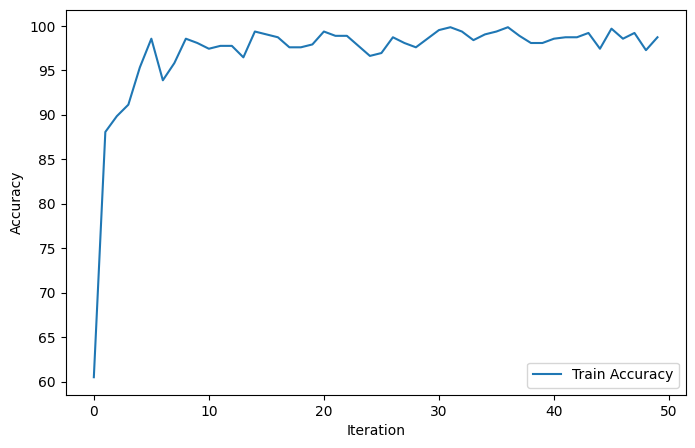

In [21]:
# Plot graphs
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.figure(figsize=(8, 5)) 
plt.plot(train_acc, label='Train Accuracy')
plt.legend()             
plt.ylabel('Accuracy')
plt.xlabel('Iteration')

plt.figure(figsize=(8, 5))
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Iteration')

plt.figure(figsize=(8, 5)) 
plt.plot(val_acc, label='Validation Accuracy')
plt.legend()             
plt.ylabel('Accuracy')
plt.xlabel('Iteration')

plt.show() # Show graphs

<h1>For saving the model</h1>

In [23]:
import pickle
# Save entire model to pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)
    
print('Model pickled and saved as "model.pkl"')

Model pickled and saved as "model.pkl"


<h1>For loading the saved model, For prediction</h1>

In [24]:
with open('model.pkl', 'rb') as f:
    model1 = pickle.load(f)
   
print('Model loaded')

Model loaded


In [33]:
import torch
import torchvision.models as models
from PIL import Image
from torchvision import transforms

# Load image
img_path = '/kaggle/input/dibas-dataset/Bacteroides.fragilis/Bacteroides.fragilis_0002.tif' 
img = Image.open(img_path)

# Transform image to tensor
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

model1.eval()
# Inference
out = model1(batch_t)

# Print predictions
max_score, idx = torch.max(out, 1)
print(max_score, idx)

tensor([5.1620], grad_fn=<MaxBackward0>) tensor([2])


In [31]:
out

tensor([[-0.8468,  0.1344,  5.1620, -1.1107, -0.7107, -1.1757, -1.1541, -0.6605,
          0.9806,  3.3715, -1.8079, -0.6681, -0.7863,  3.6174,  0.5434, -1.0757,
         -1.2625, -0.8832, -0.8092,  0.9060, -1.0387, -0.1575, -0.7114, -1.0024,
          4.1378, -1.3389,  1.5986,  0.6763, -0.0689, -1.8291, -1.9236, -0.9697,
         -0.3422]], grad_fn=<AddmmBackward0>)